In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

# Additional scklearn functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV   
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

# Classifiers
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
rcParams['figure.figsize'] = 12, 4


In [63]:
data = pd.read_csv("Training_Dataset.csv")

In [64]:
data.drop('mvar1', axis=1, inplace=True)

cool = pd.get_dummies(data['mvar12'])
data = pd.concat([data, cool], axis=1)
data.drop(['mvar12'], axis=1, inplace=True)

data['card_extension'] = data['mvar46'] + 2*data['mvar47'] + 3*data['mvar48']
data.drop(['mvar46', 'mvar47', 'mvar48'], axis=1, inplace=True)

data['card_acceptance'] = data['mvar49'] + 2*data['mvar50'] + 3*data['mvar51']
data.drop(['mvar49', 'mvar50', 'mvar51'], axis=1, inplace=True)

In [65]:
y_extension = data['card_extension']
y_acceptance = data['card_acceptance']
data.drop(['cm_key','card_extension','card_acceptance','Finance            ', 'Entertainment      ', 'Manufacturing      ', 'Apparel','Transport          ', 'Produce            ', 'Construction       ', 'Mining             ', 'Durable goods      '], 
              axis=1, inplace=True)
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)


In [66]:
#X_train, X_test,y_train_acceptance,y_test_acceptance = train_test_split(data,y_acceptance, test_size=0.33,stratify=y_acceptance)


In [67]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [68]:
print('Original dataset shape {}'.format(Counter(y_acceptance)))

Original dataset shape Counter({0: 31122, 1: 3447, 3: 2777, 2: 2654})


In [69]:
oss = RandomUnderSampler(random_state=42)
data1, y_acceptance1 = oss.fit_sample(data, y_acceptance)

In [70]:
print('Resampled dataset shape {}'.format(Counter(y_acceptance1)))
print(data1.shape)
len(y_acceptance1)

Resampled dataset shape Counter({2: 2654, 0: 2654, 3: 2654, 1: 2654})
(10616, 52)


10616

In [71]:
X_train, X_test,y_train_acceptance,y_test_acceptance = train_test_split(data1,y_acceptance1, test_size=0.25,stratify=y_acceptance1)


In [72]:
def classifier_report(clf, X_train, y_train, X_test, y_test, predictors, n_classes=3, classes=[1,2,3],performCV=True, printFeatureImportance=True, cv_folds=2):
    
    #Fit classifies on traning dataset
    clf.fit(X_train[predictors], y_train)
    
    #Predict training and test set:
    dtrain_predictions = clf.predict(X_train[predictors])
    dtrain_predprob = clf.predict_proba(X_train[predictors])
    prediction = clf.predict(X_test[predictors])
    dtest_predprob = clf.predict_proba(X_test[predictors])
    
    #Print model report:
    print ("\nModel Report")
    print ("Train Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print ("Test Accuracy : %.4g" % metrics.accuracy_score(y_test, prediction))

    y = label_binarize(y_train, classes=classes)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], dtrain_predprob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), dtrain_predprob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print("AUC Score (Train): %f" % roc_auc["micro"])  
    
    y1 = label_binarize(y_test, classes=classes)
    # Compute ROC curve and ROC area for each class
    fpr1 = dict()
    tpr1 = dict()
    roc_auc1 = dict()
    for i in range(n_classes):
        fpr1[i], tpr1[i], _ = roc_curve(y1[:, i], dtest_predprob[:, i])
        roc_auc1[i] = auc(fpr1[i], tpr1[i])

    # Compute micro-average ROC curve and ROC area
    fpr1["micro"], tpr1["micro"], _ = roc_curve(y1.ravel(), dtest_predprob.ravel())
    roc_auc1["micro"] = auc(fpr1["micro"], tpr1["micro"])
    print("AUC Score (Test): %f" % roc_auc1["micro"])  
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(clf.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [73]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)



Model Report
Train Accuracy : 0.9995
Test Accuracy : 0.6345
AUC Score (Train): 0.999999
AUC Score (Test): 0.863041


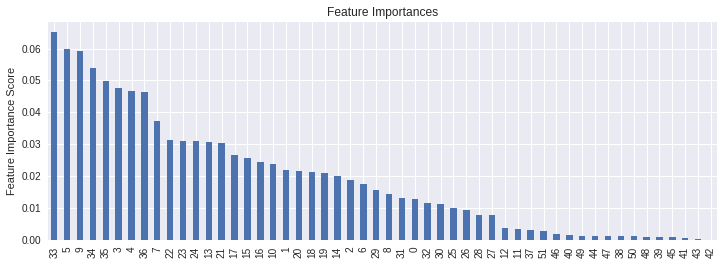

In [142]:
predictors = [x for x in X_test.columns]
gbm1 = GradientBoostingClassifier(learning_rate=0.1,
                                  n_estimators=350,
                                  min_samples_split=30,
                                  min_samples_leaf=50,
                                  max_depth=8,
                                  max_features=11,
                                  subsample=0.8,
                                  random_state=19)

classifier_report(gbm1, X_train, y_train_acceptance, X_test, y_test_acceptance, predictors, 4, [0,1,2,3])

In [102]:
#ClusterCentroids

In [103]:
con_pred = gbm1.predict(data)

In [104]:
unique, counts = np.unique(con_pred, return_counts=True)
print('full confidence')
print(np.asarray((unique, counts)).T)


full confidence
[[    0 13238]
 [    1  8592]
 [    2 10797]
 [    3  7373]]
